# Graph Neural Network
---
> Graph neural network model for vertex dynamics and tension prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import numpy as np
import torch
from os import path
import datetime

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 16 # use 14 for presentation

In [3]:
from simgnn.datasets import persistence_loss, VertexDynamics, HaraMovies, HaraAblation
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure, Reshape_x, TransformTension, RecoilAsTension
# from torch_geometric.utils import to_undirected as T_undir

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


## Training

Notes for normalisation param-s:

- Use `simgnn.transforms` to normalise real--Hara movies and ablation,  and simulated movies. Use same normalisation constants for all simulated movies.
- For ablation movies, convert to  HaraMovies length scale (pixels) and use same `l_av` as for HaraMovies dataset.

---
|Dataset| Avg. edge len.|Tension/Recoil| Transforms (Normalisation)|Notes|
|:---:|---:|---:|:---|:---:|
|`single_distr_sims` | 1.08 a.u. | range=[0.00131, 4.26]; sd=0.637; median=0.305; mean=0.578; | `[Pos2Vec(scale=10*1.0)`, `ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)]`| synthetic; w/o base tension |
|`unimodal_wbasetens_sims` | 0.906 a.u. | range=[0.407, 5.47]; sd=0.729; median=1.48; mean=1.6| `[Pos2Vec(scale=10*1.0)`, `ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)]`| synthetic; w/ non-zero base tension |
|`HaraMovies`  | 26.32 pixels||`[Pos2Vec(scale=10*26.32)`, `ScaleVelocity(0.5*26.32)]`| tissue movies w/o force data|
|`HaraAblation`|$26.32\cdot\frac{0.4}{0.21}$ pixels| range=[0.0239, 2.61]; sd=0.651; median=0.673; mean=0.826 | `[Pos2Vec(scale=10*50.13), ScaleVelocity(0.5*50.13)]`| short movies w/ recoil data; frame rate:dataset contains vertex positions only from every 10th frame |

- Logarithm of tension: ln(Tension/Recoil {raw values})
```
Single_distr_sims:        range: [-6.63 1.45]; s.d.: 1.22 || median: -1.19; mean: -1.2;
Unimodal_wbasetens_sims : range: [-0.9  1.7]; s.d.: 0.451 || median: 0.39; mean: 0.371;
Hara ablation:            range: [-3.73 0.958]; s.d.:0.962 || median:-0.396; mean:-0.547;
```


---
- **Normalisation param-s**

In [28]:
# Data normalisation param-s : sim="default" for simulation data
# Average edge lengths
l_0 = {'sim':1.0, 'single_distr_sims':1.1, 'unimodal_wbasetens_sims':0.91, 'hara':26.32, 'abln':50.13}

# Stat-s for raw tension/recoil values
t_av = {'sim':0.6, 'single_distr_sims': 0.58, 'unimodal_wbasetens_sims': 1.6, 'abln': 0.83}
t_sd = {'sim':0.63, 'single_distr_sims': 0.64, 'unimodal_wbasetens_sims':0.73 , 'abln': 0.65}

# Stat-s for log tension/recoil values
t_av_log = {'sim':0.0, 'single_distr_sims': -1.2, 'unimodal_wbasetens_sims': 0.37, 'abln': -0.55}
t_sd_log = {'sim':1.0, 'single_distr_sims': 1.2, 'unimodal_wbasetens_sims':0.45 , 'abln': 0.96}

### Datasets

In [55]:
!rm -dr simgnn_data/single_distr_sims/train/processed
!rm -dr simgnn_data/single_distr_sims/val/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/train/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed

!rm -dr simgnn_data/hara_movies/processed/
!rm -dr simgnn_data/hara_ablation/processed/

# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/

rm: cannot remove 'simgnn_data/single_distr_sims/train/processed': No such file or directory


In [56]:
window_size = 5
print(f'> Set features window size (#past velocities) to {window_size}')

> Set features window size (#past velocities) to 5


In [114]:
# Normalisation
# for simulated data (simul params ~ normal distr-s): l0_sim=1.0, l0_HaraMovie: l0=26.32
Tnrm = {} # dict of transforsm

# Default for all simulations:
Tnrm['sim'] = T.Compose([Pos2Vec(scale=10*l_0['sim']) , ScaleVelocity(0.5*l_0['single_distr_sims']),
#                          TransformTension(torch.log), ScaleTension(t_sd_log['sim'], shift=t_av_log['sim']),
                         ScaleTension(t_sd['sim'], shift=t_av['sim']),
                         Reshape_x((-1,window_size*2)) ] )

# w/o base contractility:
Tnrm['single_distr_sims'] = T.Compose([Pos2Vec(scale=10*l_0['single_distr_sims']) , ScaleVelocity(0.5*l_0['single_distr_sims']),
#                                        TransformTension(torch.log), ScaleTension(t_sd_log['single_distr_sims'], shift=t_av_log['single_distr_sims']),
                                       ScaleTension(t_sd['single_distr_sims'], shift=t_av['single_distr_sims']),
                                       Reshape_x((-1,window_size*2)) ] )

# w/ base contractility:
Tnrm['unimodal_wbasetens_sims'] = T.Compose([Pos2Vec(scale=10*l_0['unimodal_wbasetens_sims']) , ScaleVelocity(0.5*l_0['unimodal_wbasetens_sims']),
#                                              TransformTension(torch.log), ScaleTension(t_sd_log['unimodal_wbasetens_sims'], shift=t_av_log['unimodal_wbasetens_sims']),
                                             ScaleTension(t_sd['unimodal_wbasetens_sims'], shift=t_av['unimodal_wbasetens_sims']),
                                             Reshape_x((-1,window_size*2)) ] )

# Hara ablation norm
Tnrm['abln'] = T.Compose([Pos2Vec(scale=10*l_0['abln']), ScaleVelocity(0.5*l_0['abln']), RecoilAsTension(),
#                           TransformTension(torch.log),ScaleTension(t_sd_log['abln'], shift=t_av_log['abln']),
                          ScaleTension(t_sd['abln'], shift=t_av['abln']),
                          Reshape_x((-1,window_size*2))]) 

# Hara movie dataset norm
Tnrm['hara'] = T.Compose([Pos2Vec(scale=10*l_0['hara']) , ScaleVelocity(0.5*l_0['hara']), Reshape_x((-1,window_size*2))]) 

In [115]:
hara_abln = HaraAblation('simgnn_data/hara_ablation/', window_size=window_size, transform=Tnrm['abln'], smoothing=True, sma_lag_time=4)
hara = HaraMovies('simgnn_data/hara_movies/',window_size=window_size, transform=Tnrm['hara'], smoothing=True, sma_lag_time=4)

# Hara movie datasets
# seg001 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg001/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
# seg001_raw = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorm_hara)
# seg003 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg003/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
# seg005 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg005/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)

# Simulation datasets
sim1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size, 
                      transform=Tnrm['unimodal_wbasetens_sims']) # rand base contractility
sim1_val = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/', window_size=window_size,
                          transform=Tnrm['unimodal_wbasetens_sims'])
# sim2 = VertexDynamics('./simgnn_data/single_distr_sims/train/', window_size=window_size, transform=Tnorm) # no base contractility
sim2_val = VertexDynamics('./simgnn_data/single_distr_sims/val/', window_size=window_size,
                          transform=Tnrm['single_distr_sims'])


datasets_dict = {'train': sim1,
                 'val': sim1_val,
                 'val2': sim2_val,
                 'hara' : hara,
                 'abln': hara_abln}
dataset_legend={'train': 'Train(sim1)',
                'val': 'Val(sim1)',
                'val2': 'Val(sim2)',
                'hara': 'Hara',
                'abln': 'Recoil'}

Val(sim2)
val2 : VertexDynamics(112)
size:112

Frame 1:
CellData(cell2node_index=[2, 768], cell_pressures=[128], edge_attr=[431, 2], edge_index=[2, 431], edge_tensions=[431], node2cell_index=[2, 768], pos=[304, 2], x=[304, 10], y=[304, 2])


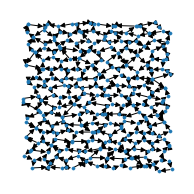

In [37]:
k='val2'
print('{}\n{} : {}\nsize:{}\n\nFrame 1:\n{}'.format(dataset_legend[k],k,datasets_dict[k],len(datasets_dict[k]),datasets_dict[k][0]))
plt.figure(figsize=[2.5,2.5])
nx.draw(to_networkx(datasets_dict[k][0]),pos=dict(enumerate(datasets_dict[k][0].pos.numpy())), node_size=10)

#### Persistence Loss

In [10]:
print('Persistence:')
for k in datasets_dict:
    if k=='abln':print('Ignoring ablation data velocity');continue
    print(f'\t- {dataset_legend[k]}: {persistence_loss(datasets_dict[k])}')

Persistence:
	- Train(sim1): {'mae': 0.06756853, 'mse': 0.008532567}
	- Val(sim1): {'mae': 0.06426177, 'mse': 0.007703601}
	- Val(sim2): {'mae': 0.063635536, 'mse': 0.008163488}
	- Hara: {'mae': 0.023777857, 'mse': 0.0009641348}
Ignoring ablation data velocity


In [9]:
len(datasets_dict['train'])

280

**To-Do**👷🚧
- need a func-n w/ a **rollout error**,
- convert vel-y error to **position error**
- *Training loop*:
    - [ ] Combine `Message` and `AggregateUpdate` into a graph layer `GraphBlock`
- [ ] Write *prediction stage*: read \{test, val, train\} data for rollout error measurements.
- [ ] Experiments (**save all models** w/ backups; will need to test on the real tensions)<br>
*Params*: edge attrib-s, cell layer, arch(skip con-s), input noise (for long term prediction). *Errors*: 1-step, and rollout error (check after training at test time).
    1. Experiment with GN arch-s w/ *residual* (w/ skip) and *non-residual* architectures.
    1. *Edge directions experiment*: train w/ and w/o edge dir-s, do edge dir-s help to speed up training?
    1. *Cell layer*: does having dedicated cell processing layer help to increase the accuracy?
    1. For best (resnet or non-resnet) run *number of layers and dim-n sizes*. Try deep nets, how does accuracy change with increasing the depth of the net?
    1. If resnet is better: try w/and w/o edge dir-s and "cell layers".
    1. Number of previous velocities (window size).
    1. Rollout experiment 1— *input noise*: according to Sanchez-Gonzalez, *et al.* \[ASG2020\], Brownian noise improves rollout accuracies (long term accuracy of the whole movie, and/or prediction stability/robustness).
    1. Rollout experiment 2— *rollout training*: train directly on rollout, i.e. use 5- and 10-step loss instead of a 1-step loss for training (slower training).
    1. Optional:
        - compare MLP vs CONV layers for message passing.
        - try with dynamic graphs (construct graphs on the fly based on relative positions, and use cell edges and cell attrib only for queries on `Y_edge`, `Y_cell`).
- [ ] Ablation dataset (*real*).

---
**DOING**🛠
1. Construct graph net without skip connections.
1. Combine Message and AggregateUpdate into a graph layer GraphNet (GN) block, a more general block, that can be composed into a deep residual network. "AddGN" block, w/ `AddGN(x) = f(x)+x` form (in fact, where it's possible make all blocks with this form.
1. Construct residual net out of GNs.
---

- **Examples**:
    - General "Message Passing" schemes: a nice example for composite graph layer –"meta layer" consisting of "edge", "node" and "global" layers [link](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer)

**Node-to-Cell Encoding/Pooling Layer**:
1. Initiate node-to-cell edge attr-s as (source) node attr-s `x[node2cell_index[0]]`.
1. Compute node-to-cell edge attr-s using MLP: `e_n2c = MLP( x[node2cell_index[0]] )`
1. Aggregate node-to-cell edge attr-s as cell attr-s : `x_cell = Aggregate(e_n2c)`
1. Compute new cell attr-s using (encodes `x_cell` into cell attr-s) : `h_cell = MLP_Cell_encoder( x_cell )`

```python
n2c_model = mlp(...) # "message", just node-wise MLP
cell_aggr = Aggregate()
cell_enc = mlp(...)

e_n2c = n2c_model(data.x)[data.node2cell_index[0]]
x_cell = cell_aggr(data.cell_pressures.size(0), data.node2cell_index, e_n2c)
h_cell = cell_enc(x_cell)
```

---
- **Adding noise from M steps**: Sum of M normal rand. var-s results in normal var. w/ variance M and s.t.d.=sqrt(M):
```python
x = np.random.normal(size=(5,1000))
y = x.sum(axis=0)
z = np.random.normal(size=(1,1000))*np.sqrt(5)
plt.hist(x.ravel(),bins=50,label='x',density=True)
plt.hist(y        ,bins=50,label='y',density=True)
plt.hist(z.ravel(),bins=50,label='z',density=True,alpha=.5)
plt.legend();
```

---

#### Single MP Step Tension Model

In [116]:
from simgnn.train import train_model, write_log, load_log, plot_losses
from simgnn.train import predict, predict_batch, plot_velocity_predictions, plot_tension_prediction

In [117]:
from simgnn.nn import SingleMP_Tension

In [118]:
torch.manual_seed(0)

dropout_p = 0
num_epochs = 30
lr = 0.001
bs = 4
loss_func = torch.nn.MSELoss(reduction='mean')
# loss_func = torch.nn.L1Loss(reduction='mean')

net = SingleMP_Tension(node_in_features=window_size*2, node_out_features=2, edge_in_features=2,
                       message_out_features=32, message_hidden_dims=[64,32,32],
                       tension_hidden_dims=[32,16,8,4],
                       aggr='mean', update_hidden_dims=[32,32,16,8], dropout_p=dropout_p).to(device)

opt = torch.optim.Adam(net.parameters(), lr=lr)
# opt = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = None
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

# in order to track the batch id for var-s add its key to "follow_batch":
loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs),
           'val':    DataLoader(datasets_dict['val'],  batch_size=bs),
           'val2':   DataLoader(datasets_dict['val2'], batch_size=bs),
           'abln':   DataLoader(datasets_dict['abln'], batch_size=bs),
           'hara':   DataLoader(datasets_dict['hara'], batch_size=bs)
          }
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids

model_states = list(loaders.keys())
use_force_loss = {'train':[True,False], 
                  'val':[True, False],
                  'val2':[True,False] ,
                  'abln':[True,False] ,
                  'hara' : [False, False]
                 }# [tension, pressure]

return_best = False

model_name = datetime.datetime.now().strftime('%d%m%Y_%H%M%S')+f'_{net.__class__.__name__}_dp{dropout_p}bs{bs}w{window_size}{"best" if return_best else ""}'
save_dir = './simgnn_data/saved_models/'

In [119]:
print(model_name,end='\n---\n')

net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=scheduler, device=device, model_states = model_states,
                               loss_func = loss_func, use_force_loss=use_force_loss, return_best=return_best)

25082021_080824_SingleMP_Tension_dp0bs4w5
---
Training param-s: #epochs=30, metric=MSELoss(), batch_size=4, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/29: train_loss_tot=   1.093; train_loss_y= 0.01986; train_loss_T=   1.073; |val_loss_tot=  0.9877; |val2_loss_tot=   1.004; |abln_loss_tot=   1.059; |hara_loss_tot=0.000869; |7s
Epoch 1/29: train_loss_tot=   1.039; train_loss_y=0.006277; train_loss_T=   1.033; |val_loss_tot=  0.9595; |val2_loss_tot=  0.9744; |abln_loss_tot=   1.027; |hara_loss_tot=0.0004613; |14s
Epoch 2/29: train_loss_tot=   1.008; train_loss_y=0.003433; train_loss_T=   1.004; |val_loss_tot=  0.9496; |val2_loss_tot=   0.962; |abln_loss_tot=   1.012; |hara_loss_tot=0.0004456; |21s
Epoch 3/29: train_loss_tot=  0.9897; train_loss_y= 0.00274; train_loss_T=  0.9872; |val_loss_tot=  0.9328; |val2_loss_tot=  0.9397; |abln_loss_tot=   1.003; |hara_loss_tot=0.0004911; |27s
Epoch 4/29: train_loss_tot=  0.8537; train_loss_y=0.003117; train_loss_T=  0.8506; |val_loss_tot

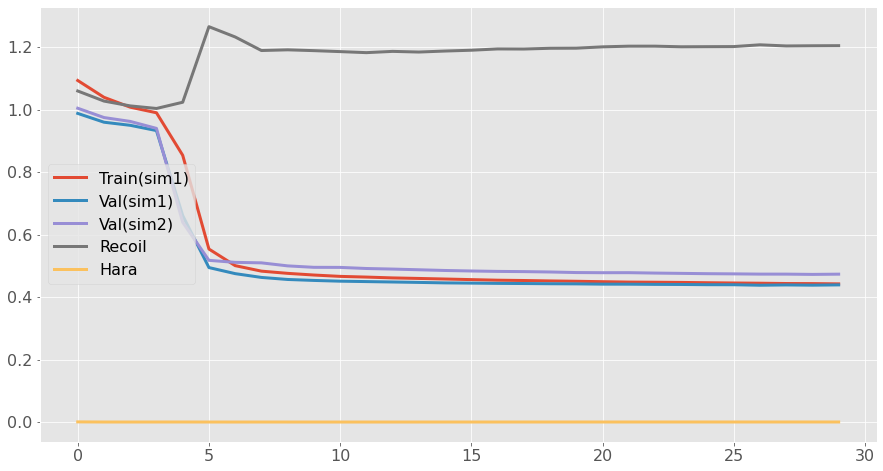

In [120]:
# plot losses
plot_losses(train_log, loaders, dataset_legend); plt.show()

- train_loss_tot =0.44309884607278954;
- train_loss_y =0.0013552003714454488;
- train_loss_T =0.4418081627989599;
- train_loss_P =None;
- val_loss_tot =0.4391205123922303;
- val_loss_y =0.0011609956150817127;
- val_loss_T =0.4379408032797613;
- val_loss_P =None;
- val2_loss_tot =0.4734398296901158;
- val2_loss_y =0.0012680090084230718;
- val2_loss_T =0.4721120977091053;
- val2_loss_P =None;
- abln_loss_tot =1.2043480983928703;
- abln_loss_y =0.0;
- abln_loss_T =1.203681769766069;
- abln_loss_P =None;
- hara_loss_tot =0.0005669628276466407;
- hara_loss_y =0.0005669628276466407;
- hara_loss_T =None;
- hara_loss_P =None;



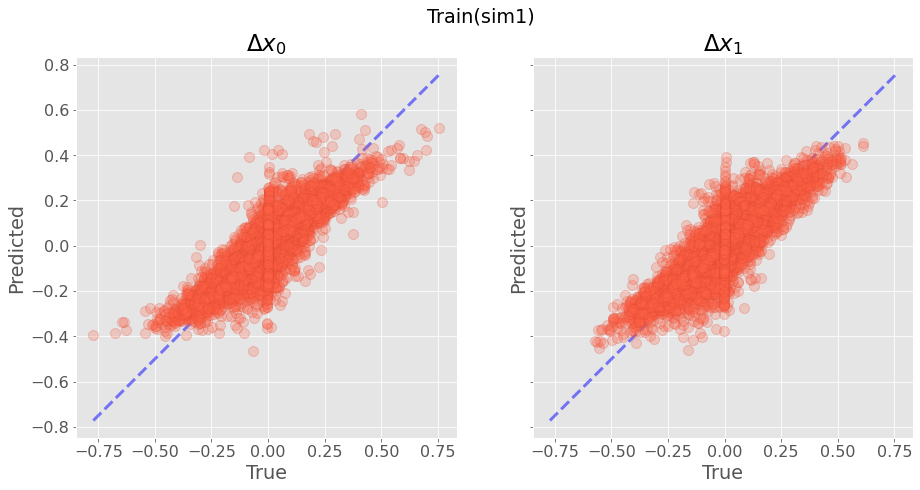

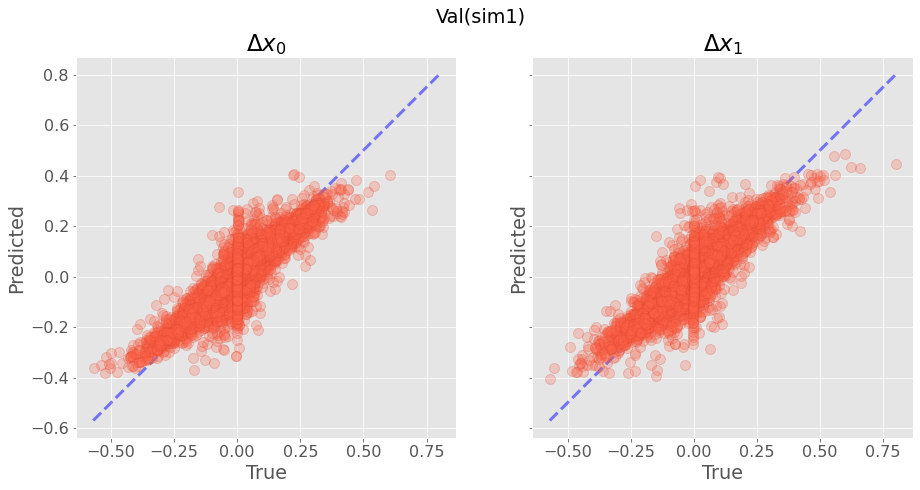

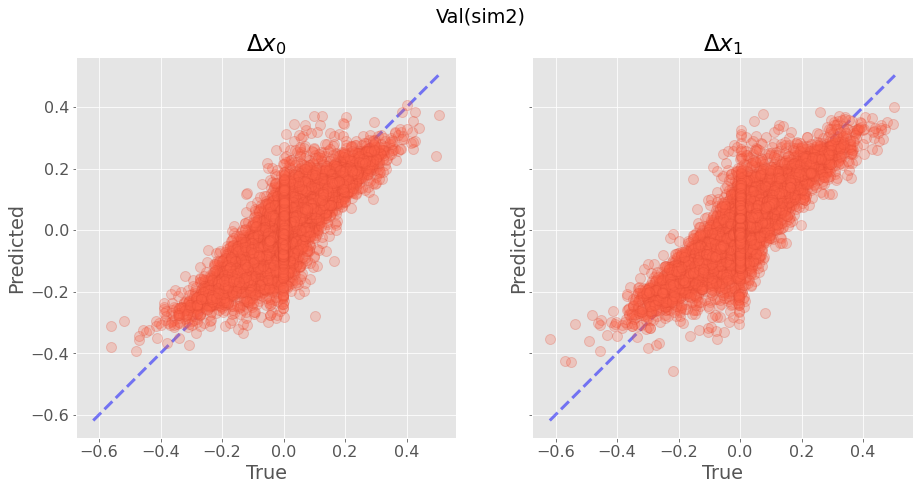

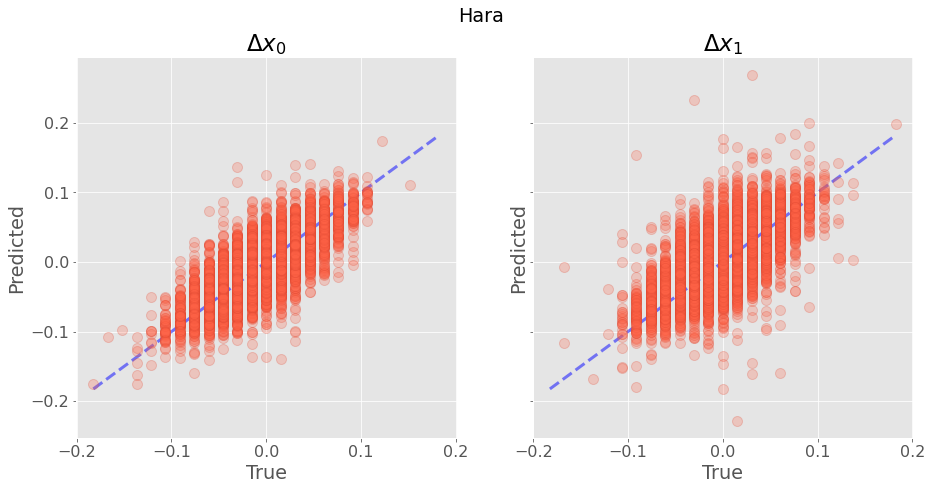

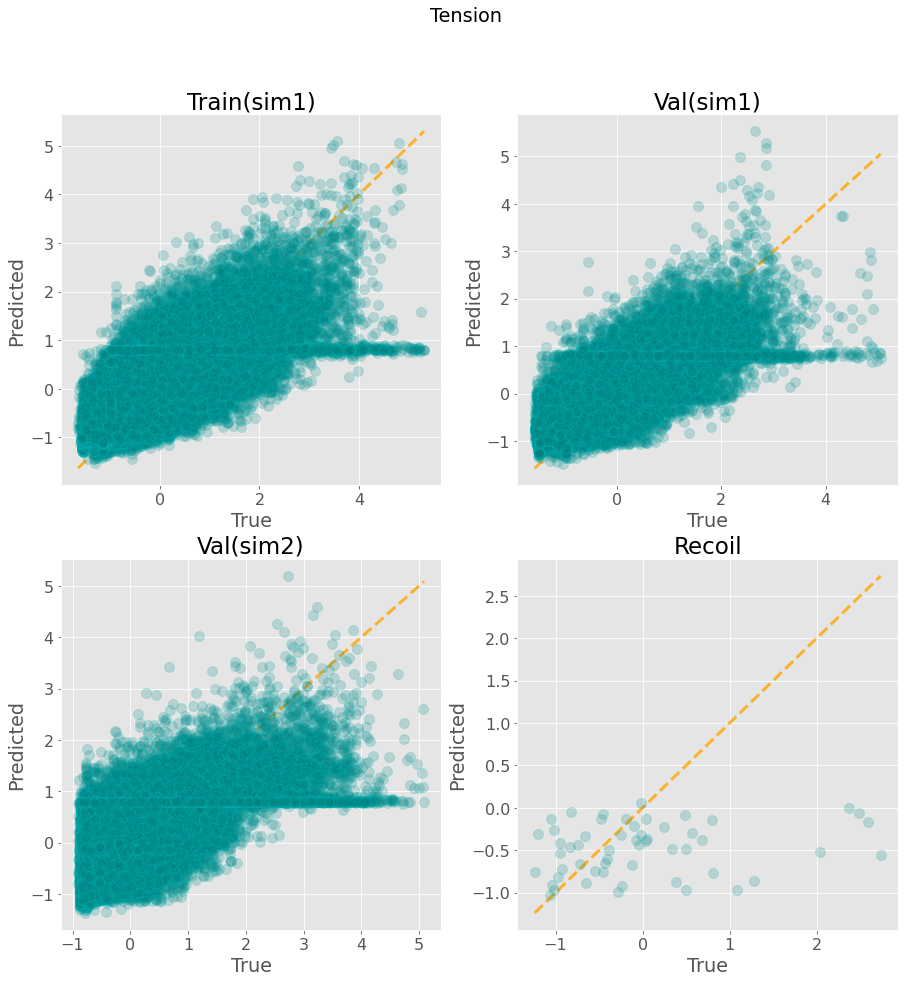

In [121]:
# compute predictions and plot them
pred_out, tgt_out, sample_losses = predict_batch(net, loaders, loss_func=torch.nn.MSELoss(reduction='mean'),
                                                 use_force_loss = use_force_loss, return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

plot_tension_prediction(pred_out[1], tgt_out[1], dataset_legend,figsize=[15,15],nrows=2,ncols=2)

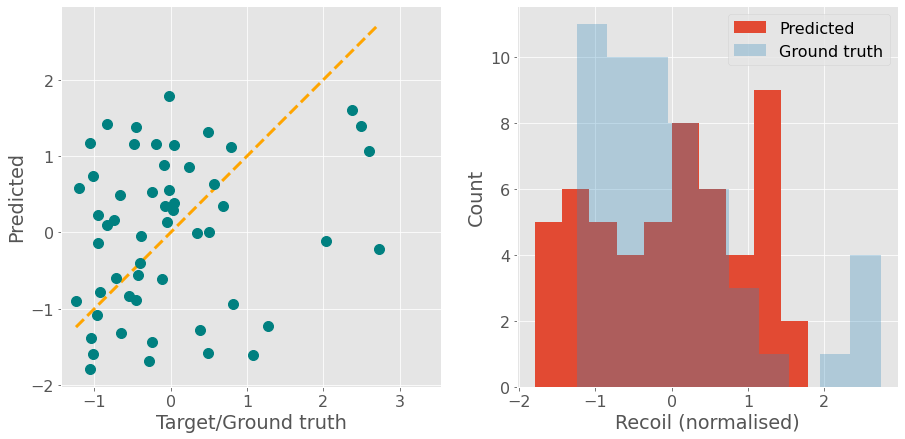

In [122]:
y_gt = torch.cat(tgt_out[1]['abln'],axis=0).numpy()

y_pred = torch.cat(pred_out[1]['abln'],axis=0).numpy()
y_pred_scaled = (y_pred[~np.isnan(y_gt)] - y_pred[~np.isnan(y_gt)].mean())/y_pred[~np.isnan(y_gt)].std()

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=[15,7])
axs = axs.ravel()
axs[0].plot([y_gt[~np.isnan(y_gt)].min(),y_gt[~np.isnan(y_gt)].max()],
            [y_gt[~np.isnan(y_gt)].min(),y_gt[~np.isnan(y_gt)].max()],'--',c='orange',lw=3)
axs[0].plot(y_gt[~np.isnan(y_gt)], y_pred_scaled, 'o',ms=10,c='teal')
axs[0].axis('square')
axs[0].set_xlabel('Target/Ground truth')
axs[0].set_ylabel('Predicted')

axs[1].hist(y_pred_scaled,label='Predicted')
axs[1].hist(y_gt,alpha=.3, label='Ground truth');
axs[1].set_xlabel('Recoil (normalised)')
axs[1].set_ylabel('Count')
axs[1].legend();

In [128]:
y_gt[~np.isnan(y_gt)].mean()

-0.006196609